## 1) Data Analysis

In [12]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[0]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nShapes:")
for key, tensor in sample.items():
    print(f"{key}: {tensor.shape}")

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()


Sample contains the following keys:
- sdf
- grasps
- scores

Shapes:
sdf: torch.Size([48, 48, 48])
grasps: torch.Size([480, 7])
scores: torch.Size([480])

Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasps:
  Min: -0.5236
  Max: 1.8326
  Mean: 0.1521
  Std: 0.4945

scores:
  Min: -1.5000
  Max: 8.6819
  Mean: 1.6106
  Std: 2.8319



## 2) Overfitting on 1 sample

In [13]:
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

### 2.1) Initialize the model

In [14]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1218977


### 2.2) Get a small number of samples

In [15]:
# Create dataset
data_path = Path('data/processed')

dataset = GraspDataset(data_path)

scene = dataset[0]

def get_samples(scene, num_samples):
    # Get num_samples many unique indices
    indices = torch.randperm(len(scene['grasps']))[:num_samples]
    samples = []
    for i in indices:
        sample = {
            'grasps': scene['grasps'][i].float().to(device),
            'scores': scene['scores'][i].float().to(device),
            'sdf': scene['sdf'].float().to(device)
        }
        samples.append(sample)
    return samples

samples = get_samples(scene, 1)

for i, sample in enumerate(samples[:3]):
    print(f"Sample {i}:")
    print("\tgrasps: ", sample['grasps'].tolist())
    print("\tscore: ", sample['scores'].item())


print(samples[0]['grasps'].shape)
print(samples[0]['scores'].shape)
print(samples[0]['sdf'].shape)



Sample 0:
	grasps:  [-0.1362624615430832, -0.14802123606204987, 0.8109341263771057, -0.13547779619693756, -0.2425919622182846, -0.03906584903597832, 0.1332123726606369]
	score:  7.935917854309082
torch.Size([7])
torch.Size([])
torch.Size([48, 48, 48])


### 2.3) Overfit on these samples from that one scene

[61.31660461425781, 61.21823501586914, 61.12983703613281, 61.046546936035156, 60.97214889526367, 60.89933395385742, 60.808773040771484, 60.68621826171875, 60.55746841430664, 60.402164459228516, 60.22419738769531, 60.001708984375, 59.69839096069336, 59.31230163574219, 58.82781982421875, 58.3118782043457, 57.68958282470703, 56.889556884765625, 55.87755584716797, 54.602195739746094, 53.021732330322266, 51.06917953491211, 48.66050338745117, 45.780521392822266, 42.334693908691406, 38.26511764526367, 33.53634262084961, 28.15090560913086, 22.216075897216797, 15.908470153808594, 9.663140296936035, 4.179488182067871, 0.6046392321586609, 0.433000385761261, 4.225284099578857, 8.645532608032227, 9.92825984954834, 8.119023323059082, 5.01828670501709, 2.220625162124634, 0.5215513706207275, 0.0002885529538616538, 0.33443695306777954, 1.094122052192688, 1.9174754619598389, 2.5688040256500244, 2.9296326637268066, 2.966153144836426, 2.7060515880584717, 2.2180747985839844, 1.6000316143035889, 0.965953052

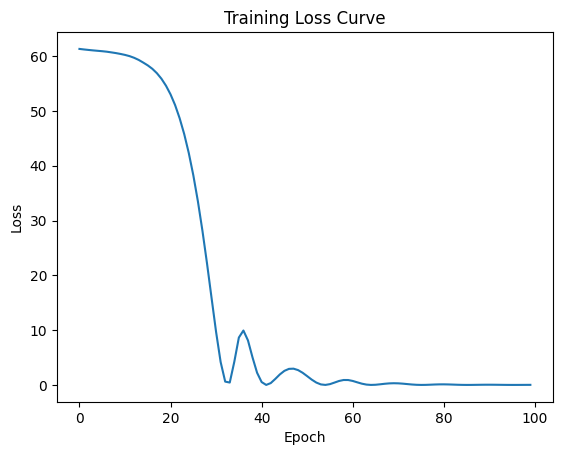

In [16]:
EPOCHS = 100

losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for sample in samples:
        optimizer.zero_grad()
        pred_quality = model(sample['sdf'], sample['grasps'])
        loss = criterion(pred_quality, sample['scores'])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(samples)
    losses.append(epoch_loss)

print(losses)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


## 3) Full Training

### 3.1) Initialize a new model

In [17]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1218977


### 3.2) Create the datasets

In [18]:
from torch.utils.data import random_split, DataLoader

# Load the dataset
dataset = GraspDataset(data_path)
# Create a subset of the dataset using a list comprehension to properly handle file paths
subset_indices = list(range(100))
dataset = torch.utils.data.Subset(dataset, subset_indices)

# Split dataset into training and validation
val_split = 0.2
num_samples = len(dataset)

train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

batch_size = 1 # 1 scene per iteration

# Create train/val splits with fixed seed
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Create DataLoaders with shuffling
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(42)
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=True,
    generator=torch.Generator().manual_seed(42)
)


Subset samples: 100, Calculated train size: 80, Calculated val size: 20


In [11]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
num_epochs = 100 
train_losses = []
val_losses = []

print(f"\nStarting quick training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    num_train_batches_processed = 0

    for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        
        # For now, we are only working with batches of size 1,
        # so the model is not designed to handle batch data
        # Therefore, we have to unbatch the data
        
        sdf = batch_data['sdf'].float().to(device).squeeze(0)
        hand_pose_batch = batch_data['grasps'].float().to(device).squeeze(0)
        scores_batch = batch_data['scores'].float().to(device).squeeze(0)

        num_grasps_in_sample = hand_pose_batch.shape[0]
        if num_grasps_in_sample == 0: continue

        batch_sample_train_loss = 0.0
        optimizer.zero_grad()
        for i in range(num_grasps_in_sample): # Consider limiting i for extreme speed up, e.g. range(min(num_grasps_in_sample, 5))
            current_hand_pose = hand_pose_batch[i]
            current_score = scores_batch[i]
            
            pred_quality = model(sdf, current_hand_pose)
            loss = criterion(pred_quality, current_score)
            loss.backward()
            batch_sample_train_loss += loss.item()
        
        optimizer.step()
        epoch_train_loss += (batch_sample_train_loss / num_grasps_in_sample)
        num_train_batches_processed +=1

    avg_epoch_train_loss = epoch_train_loss / num_train_batches_processed
    train_losses.append(avg_epoch_train_loss)

    avg_epoch_val_loss = float('nan')
    if val_dataloader:
        model.eval()
        epoch_val_loss = 0.0
        num_val_batches_processed = 0
        with torch.no_grad():
            for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
                sdf = batch_data['sdf'].float().to(device).squeeze(0)
                hand_pose_batch = batch_data['grasps'].float().to(device).squeeze(0)
                scores_batch = batch_data['scores'].float().to(device).squeeze(0)

                num_grasps_in_sample = hand_pose_batch.shape[0]

                batch_sample_val_loss = 0.0
                for i in range(num_grasps_in_sample): # Consider limiting i
                    current_hand_pose = hand_pose_batch[i]
                    current_score = scores_batch[i]
                    
                    pred_quality = model(sdf, current_hand_pose)
                    loss_val = criterion(pred_quality, current_score)
                    batch_sample_val_loss += loss_val.item()
                
                epoch_val_loss += (batch_sample_val_loss / num_grasps_in_sample)
                num_val_batches_processed +=1
        
    avg_epoch_val_loss = epoch_val_loss / num_val_batches_processed
    val_losses.append(avg_epoch_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}')

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plot_val_epochs = [i for i, vl in enumerate(val_losses) if not (isinstance(vl, float) and math.isnan(vl))]
plot_val_losses_values = [vl for vl in val_losses if not (isinstance(vl, float) and math.isnan(vl))]
if plot_val_losses_values:
   plt.plot(plot_val_epochs, plot_val_losses_values, label='Validation Loss')
plt.title(f'Training and Validation Loss, {num_epochs} Epochs, {num_samples} samples)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Starting quick training for 100 epochs...


Epoch 1/100 Training:  21%|██▏       | 17/80 [02:20<08:42,  8.30s/it]